In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)
#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


38951745

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [36]:
with open( "/home/soren/keras-oneshot/train.pickle","r") as f:
    (X,c) = pickle.load(f)

with open( "/home/soren/keras-oneshot/val.pickle","r") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
['Alphabet_of_the_Magi', 'Cyrillic', 'Gujarati', 'Japanese_(katakana)', 'Sanskrit', 'Japanese_(hiragana)', 'Korean', 'Mkhedruli_(Georgian)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Latin', 'Early_Aramaic', 'Grantha', 'Asomtavruli_(Georgian)', 'Futurama', 'Bengali', 'Armenian', 'Anglo-Saxon_Futhorc', 'Tifinagh', 'Balinese', 'Braille', 'Greek', 'Tagalog', 'N_Ko', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Burmese_(Myanmar)', 'Hebrew', 'Syriac_(Estrangelo)']
validation alphabets:
['Atemayar_Qelisayer', 'ULOG', 'Sylheti', 'Angelic', 'Glagolitic', 'Aurek-Besh', 'Oriya', 'Avesta', 'Kannada', 'Tengwar', 'Keble', 'Mongolian', 'Gurmukhi', 'Ge_ez', 'Malayalam', 'Atlantean', 'Old_Church_Slavonic_(Cyrillic)', 'Tibetan', 'Syriac_(Serto)', 'Manipuri']


In [37]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path):
        self.data = {}
        self.categories = {}
        self.info = {}
        with open(os.path.join(path,"train.pickle"),"r") as f:
            (X,c) = pickle.load(f)
            self.data["train"] = X
            self.categories["train"] = c
        with open(os.path.join(path,"val.pickle"),"r") as f:
            (X,c) = pickle.load(f)
            self.data["val"] = X
            self.categories["val"] = c
            
        self.n_classes,self.n_examples,self.w,self.h = self.data["train"].shape
        self.n_val,self.n_ex_val,_,_ = self.data['val'].shape

    def get_batch(self,n,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        categories = rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n, self.h, self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = X[category,idx_1].reshape(self.w,self.h,1)
            idx_2 = rng.randint(0,self.n_examples)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else (category + rng.randint(1,self.n_classes)) % self.n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets
    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples = X.shape[0],X.shape[1]
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            indices = rng.randint(0,self.n_examples,size=(N,))
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

loader = Siamese_Loader("/home/soren/keras-oneshot")


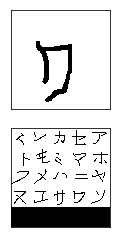

In [43]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)


In [ ]:
#Training loop
evaluate_every = 500 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32 
n_iter = 900000 
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = 9999
#siamese_net.load_weights("/home/soren/keras-oneshot/weights")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save('/home/soren/keras-oneshot/weights')
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))


In [ ]:
def nearest_neighbour(pairs,targets):
    """Quick function to classify a pair of images using 1 nearest neighbour"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour(pairs,targets)
        n_right+= correct
    return 100.0 * n_right / n_trials

#training loop
siamese_net.load_weights("/home/soren/keras-oneshot/weights")
ways = np.arange(1,60,2)
val_accs, train_accs,nn_accs = [],[],[]
print("?")
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net,N,trials,"val",verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net,N,trials,"train",verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials,loader))
import seaborn as sns
plt.plot(ways,val_accs,"m")
plt.plot(ways,train_accs,"y")
plt.plot(ways,nn_accs,"c")

plt.plot(ways,100.0/ways,"r")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [ ]:

a=test_nn_accuracy(3,500,loader)
print(a)